# CSCI 4380 — Rookie PER Prediction

In [1]:
from __future__ import annotations

import os, math, re
import numpy as np
import pandas as pd

from typing import List, Tuple, Dict, Optional

import matplotlib.pyplot as plt

# Scikit-learn: preprocessing & models
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Utility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

def ensure_dir(path: str) -> None:
    os.makedirs(path, exist_ok=True)

ensure_dir("outputs")
print("Setup complete.")


Setup complete.


In [10]:
!pip install kagglehub

In [2]:
import kagglehub

college_path = kagglehub.dataset_download("adityak2003/college-basketball-players-20092021")
combine_path = kagglehub.dataset_download("marcusfern/nba-draft-combine")
rookie_path  = kagglehub.dataset_download("thedevastator/nba-rookies-performance-statistics-and-minutes-p")

DATA_PATHS = {
    "college_csv": os.path.join(college_path, "CollegeBasketballPlayers2009-2021.csv"),
    "combine_csv": os.path.join(combine_path, "Draft Combine - Kaggle.csv"),
    "rookie_csv":  os.path.join(rookie_path,  "NBA Rookies by Year.csv"),
}

for k, v in DATA_PATHS.items():
    print(f"{k}: {v}")


c:\Users\mulli\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


college_csv: C:\Users\mulli\.cache\kagglehub\datasets\adityak2003\college-basketball-players-20092021\versions\5\CollegeBasketballPlayers2009-2021.csv
combine_csv: C:\Users\mulli\.cache\kagglehub\datasets\marcusfern\nba-draft-combine\versions\15\Draft Combine - Kaggle.csv
rookie_csv: C:\Users\mulli\.cache\kagglehub\datasets\thedevastator\nba-rookies-performance-statistics-and-minutes-p\versions\2\NBA Rookies by Year.csv


In [3]:

def clean_player_name(s: str) -> str:
    """Normalize player names across datasets (remove punctuation/suffixes, flip "Last, First")."""
    if s is None or not isinstance(s, str): return ""
    s = s.strip()
    if "," in s:
        parts = [p.strip() for p in s.split(",")]
        if len(parts) == 2:
            s = f"{parts[1]} {parts[0]}"
    s = re.sub(r"[.\u2019'`]", "", s)         
    s = re.sub(r"\b(JR|SR|II|III|IV)\b", "", s, flags=re.I)
    s = re.sub(r"\s+", " ", s)
    return s.upper().strip()

def per40(x: pd.Series, minutes: pd.Series) -> pd.Series:
    return (x / minutes.replace(0, np.nan)) * 40.0

def true_shooting_percentage(points: pd.Series, fga: pd.Series, fta: pd.Series) -> pd.Series:
    denom = 2.0 * (fga + 0.44 * fta)
    return points / denom.replace(0, np.nan)

def effective_fg_percentage(fgm: pd.Series, three_pm: pd.Series, fga: pd.Series) -> pd.Series:
    return (fgm + 0.5 * three_pm) / fga.replace(0, np.nan)

def percent_to_unit(df: pd.DataFrame, cols):
    df = df.copy()
    for c in cols:
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
            s = df[c]
            if s.dropna().gt(1.5).mean() > 0.5:
                df[c] = s / 100.0
    return df


In [4]:
def load_college(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    rename_map = {
        "player_name":"player", "team":"school", "year":"season",
        "GP":"gp", "mp":"mpg",
        "FTM":"ftm", "FTA":"fta", "FT_per":"ft_pct",
        "twoPM":"twopm", "twoPA":"twopa", "twoP_per":"twop_pct",
        "TPM":"fg3m", "TPA":"fg3a", "TP_per":"fg3_pct",
        "pts":"pts_pg","ast":"ast_pg","treb":"trb_pg","stl":"stl_pg","blk":"blk_pg",
        "eFG":"efg_pct_given","TS_per":"ts_pct_given",
        "ORB_per":"orb_pct", "DRB_per":"drb_pct", "AST_per":"ast_pct", "TO_per":"tov_pct",
        "ftr":"ftr", "Ortg":"ortg", "Drtg":"drtg",
    }
    df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})
    df = df[df.get("pick").notna()]  

    # minutes (rough)
    if {"gp", "mpg"}.issubset(df.columns):
        df["minutes"] = df["gp"] * df["mpg"]
    else:
        df["minutes"] = np.nan

    # derive basic shot totals
    df["fgm"] = df.get("twopm", 0).fillna(0) + df.get("fg3m", 0).fillna(0)
    df["fga"] = df.get("twopa", 0).fillna(0) + df.get("fg3a", 0).fillna(0)

    # keep last college season per player as “draft season”
    if {"player","season"}.issubset(df.columns):
        df = (df.sort_values(["player","season"])
                .groupby("player", as_index=False)
                .tail(1)
                .rename(columns={"season":"draft_year"}))
    return df

def load_combine(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    rename_map = {
        "PLAYER":"player","YEAR":"draft_year","POS":"position",
        "HGT":"height_w_shoes_in","WGT":"weight_lbs","BMI":"bmi","BF":"body_fat_pct",
        "WNGSPN":"wingspan_in","STNDRCH":"standing_reach_in",
        "HANDL":"hand_length_in","HANDW":"hand_width_in",
        "STNDVERT":"vert_no_step_in","LPVERT":"vert_max_in",
        "LANE":"lane_agility_sec","SHUTTLE":"shuttle_run_sec","SPRINT":"three_quarter_sprint_sec",
        "BENCH":"bench_reps",
    }
    df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})
    numeric_like = [
        "draft_year","height_w_shoes_in","weight_lbs","bmi","body_fat_pct",
        "wingspan_in","standing_reach_in","hand_length_in","hand_width_in",
        "vert_no_step_in","vert_max_in",
        "lane_agility_sec","shuttle_run_sec","three_quarter_sprint_sec",
        "bench_reps"
    ]
    for c in numeric_like:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df.drop_duplicates(subset=[c for c in ["player","draft_year"] if c in df.columns])

def load_rookie(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    unnamed = [c for c in df.columns if not str(c).strip() or str(c).lower().startswith("unnamed") or str(c).lower()=="index"]
    if unnamed: df = df.drop(columns=unnamed)
    rename_map = {
        "Name":"player","Year Drafted":"rookie_season",
        "GP":"gp","MIN":"minutes","PTS":"pts","FGM":"fgm","FGA":"fga","FG%":"fg_pct",
        "3P Made":"fg3m","3PA":"fg3a","3P%":"fg3_pct","FTM":"ftm","FTA":"fta","FT%":"ft_pct",
        "OREB":"orb","DREB":"drb","REB":"trb","AST":"ast","STL":"stl","BLK":"blk","TOV":"tov",
        "EFF":"rookie_per",
    }
    df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})
    numeric_cols = ["rookie_season","gp","minutes","pts","fgm","fga","fg_pct","fg3m","fg3a","fg3_pct",
                    "ftm","fta","ft_pct","orb","drb","trb","ast","stl","blk","tov","rookie_per"]
    for c in numeric_cols:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    df["draft_year"] = df.get("rookie_season", np.nan)
    return df.drop_duplicates(subset=["player","rookie_season"], keep="first")


In [5]:
college = load_college(DATA_PATHS["college_csv"])
combine = load_combine(DATA_PATHS["combine_csv"])
rookie  = load_rookie(DATA_PATHS["rookie_csv"])

for df in (college, combine, rookie):
    df["player"] = df["player"].astype(str).map(clean_player_name)

college_fe = college.copy()
if {"pts","minutes"}.issubset(college_fe.columns):
    college_fe["pts_per40"] = per40(college_fe["pts"], college_fe["minutes"])
if {"ast","minutes"}.issubset(college_fe.columns):
    college_fe["ast_per40"] = per40(college_fe["ast"], college_fe["minutes"])
if {"trb","minutes"}.issubset(college_fe.columns):
    college_fe["trb_per40"] = per40(college_fe["trb"], college_fe["minutes"])
if {"stl","minutes"}.issubset(college_fe.columns):
    college_fe["stl_per40"] = per40(college_fe["stl"], college_fe["minutes"])
if {"blk","minutes"}.issubset(college_fe.columns):
    college_fe["blk_per40"] = per40(college_fe["blk"], college_fe["minutes"])
if {"tov","minutes"}.issubset(college_fe.columns):
    college_fe["tov_per40"] = per40(college_fe["tov"], college_fe["minutes"])

# shooting efficiencies 
if {"fgm","fg3m","fga"}.issubset(college_fe.columns) and college_fe["fga"].notna().any():
    college_fe["efg_pct"] = effective_fg_percentage(college_fe["fgm"], college_fe["fg3m"], college_fe["fga"])
elif "efg_pct_given" in college_fe.columns:
    college_fe["efg_pct"] = college_fe["efg_pct_given"]

if {"pts","fga","fta"}.issubset(college_fe.columns) and (college_fe["fga"].notna().any() or college_fe["fta"].notna().any()):
    college_fe["ts_pct"] = true_shooting_percentage(college_fe["pts"], college_fe["fga"], college_fe["fta"])
elif "ts_pct_given" in college_fe.columns:
    college_fe["ts_pct"] = college_fe["ts_pct_given"]

# 4) Merge with combine + rookie
merged = (college_fe
          .merge(combine, on=["player","draft_year"], how="left")
          .merge(rookie[["player","draft_year","rookie_per"]], on=["player","draft_year"], how="inner"))

# convert percent-looking columns to 0..1 if needed
pct_cols = ["efg_pct_given","ts_pct_given","ft_pct","twop_pct","fg3_pct","efg_pct","ts_pct","fg_pct"]
merged = percent_to_unit(merged, pct_cols)

print("Merged shape:", merged.shape)
merged.sort_values("draft_year")[["player","draft_year"]].head(8)


Merged shape: (217, 91)


C:\Users\mulli\AppData\Local\Temp\ipykernel_21484\1997730896.py:2: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


,player,draft_year
0,AJ PRICE,2009
77,HASHEEM THABEET,2009
40,DAJUAN SUMMERS,2009
42,DANTE CUNNINGHAM,2009
44,DARREN COLLISON,2009
113,JORDAN HILL,2009
46,DEJUAN BLAIR,2009
47,DEMAR DEROZAN,2009


In [6]:
merged = pd.read_csv("outputs\merged_training_table.csv")  # rename if needed

# shape
N, F = merged.shape
print(f"Rows (players): {N}")
print(f"Columns (features): {F}")

# merged dataset statistics
target = "rookie_per" 
print("\nRookie PER Summary:")
print(f"Mean: {merged[target].mean():.2f}")
print(f"Std Dev: {merged[target].std():.2f}")
print(f"Min: {merged[target].min():.2f}")
print(f"Max: {merged[target].max():.2f}")


Rows (players): 217
Columns (features): 91

Rookie PER Summary:
Mean: 7.16
Std Dev: 3.98
Min: 2.10
Max: 23.80


<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\mulli\AppData\Local\Temp\ipykernel_21484\3893503554.py:1: SyntaxWarning: invalid escape sequence '\m'
  merged = pd.read_csv("outputs\merged_training_table.csv")  # rename if needed


In [7]:

def select_model_features(df: pd.DataFrame) -> Tuple[pd.DataFrame, List[str], List[str]]:
    numeric_candidates = [
        # college per-40 / efficiency
        "pts_per40","ast_per40","trb_per40","stl_per40","blk_per40","tov_per40",
        "efg_pct","ts_pct",
        # combine
        "height_w_shoes_in","wingspan_in","standing_reach_in","weight_lbs",
        "body_fat_pct","bench_reps","vert_no_step_in","vert_max_in",
        "lane_agility_sec","shuttle_run_sec","three_quarter_sprint_sec",
    ]
    categorical_candidates = ["position"]
    numeric_cols      = [c for c in numeric_candidates if c in df.columns]
    categorical_cols  = [c for c in categorical_candidates if c in df.columns]
    return df, numeric_cols, categorical_cols

def build_preprocessor(numeric_cols: List[str], categorical_cols: List[str]) -> ColumnTransformer:
    num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                         ("scaler",  StandardScaler())])
    cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                         ("onehot",  OneHotEncoder(handle_unknown="ignore", sparse_output=False))])
    return ColumnTransformer([("num", num_pipe, numeric_cols),
                              ("cat", cat_pipe, categorical_cols)], remainder="drop")

df_all, num_cols, cat_cols = select_model_features(merged)
feature_cols = num_cols + cat_cols
if not feature_cols:
    raise ValueError("No feature columns found—check CSV schemas.")

pre = build_preprocessor(num_cols, cat_cols)
print("Numeric features:", num_cols)
print("Categorical features:", cat_cols)


Numeric features: ['efg_pct', 'ts_pct', 'height_w_shoes_in', 'wingspan_in', 'standing_reach_in', 'weight_lbs', 'body_fat_pct', 'bench_reps', 'vert_no_step_in', 'vert_max_in', 'lane_agility_sec', 'shuttle_run_sec', 'three_quarter_sprint_sec']
Categorical features: ['position']


## Baseline: Linear Regression
As a quick baseline, we cross‑validate a plain linear regression inside the same preprocessing pipeline.

In [8]:

X = df_all[feature_cols]
y = df_all["rookie_per"]

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
lin_pipe = Pipeline([("preprocess", pre), ("model", LinearRegression())])
neg_mae = cross_val_score(lin_pipe, X, y, cv=kf, scoring="neg_mean_absolute_error")
neg_mse = cross_val_score(lin_pipe, X, y, cv=kf, scoring="neg_mean_squared_error")
r2      = cross_val_score(lin_pipe, X, y, cv=kf, scoring="r2")

baseline_metrics = {
    "MAE":  float(-neg_mae.mean()),
    "RMSE": float(np.sqrt(-neg_mse.mean())),
    "R2":   float(r2.mean()),
}
print("Linear Regression (CV):", baseline_metrics)
pd.DataFrame([baseline_metrics]).to_csv("outputs/baseline_linear_metrics.csv", index=False)


Linear Regression (CV): {'MAE': 3.264776867542962, 'RMSE': 4.245037803768917, 'R2': -0.24291014442584852}


In [9]:

def engineer_extra_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    has = df.columns.__contains__

    # Per-40 usage proxy
    fga = None
    for name in ["fga", "fga_pg", "fga_per_game", "field_goals_att"]:
        if name in df.columns: fga = df[name]; break
    fta = None
    for name in ["fta", "fta_pg", "fta_per_game", "free_throws_att"]:
        if name in df.columns: fta = df[name]; break
    tov = df.get("tov", df.get("tov_total", pd.Series(np.nan, index=df.index)))

    if "minutes" in df.columns and fga is not None and fta is not None and tov is not None:
        df["usage_proxy_per40"] = ( (fga + 0.44*fta + tov) / df["minutes"].replace(0, np.nan) ) * 40.0

    if "pts_per40" in df.columns and "mpg" in df.columns:
        df["pace_adjusted_scoring"] = df["pts_per40"] / df["mpg"].replace(0, np.nan)

    if {"wingspan_in","height_w_shoes_in"}.issubset(df.columns):
        df["ws_ratio"] = df["wingspan_in"] / df["height_w_shoes_in"]
    if {"standing_reach_in","height_w_shoes_in"}.issubset(df.columns):
        df["reach_ratio"] = df["standing_reach_in"] / df["height_w_shoes_in"]
    if {"bench_reps","vert_max_in","weight_lbs"}.issubset(df.columns):
        df["power_to_weight"] = (df["bench_reps"] * df["vert_max_in"]) / df["weight_lbs"].replace(0, np.nan)
    if {"height_w_shoes_in","weight_lbs"}.issubset(df.columns):
        h = df["height_w_shoes_in"].replace(0, np.nan)
        df["bmi_like"] = df["weight_lbs"] / (h**2)

    if {"efg_pct","ts_pct"}.issubset(df.columns):
        df["shooting_split"] = df["efg_pct"] * df["ts_pct"]
    if {"ast_per40","tov_per40"}.issubset(df.columns):
        df["ball_security"] = df["ast_per40"] / (df["tov_per40"] + 1e-6)

    return df

merged_plus = engineer_extra_features(merged)

# Extend numeric feature list to include any of the new columns that actually exist
extra_nums = [
    "usage_proxy_per40","pace_adjusted_scoring","ws_ratio","reach_ratio",
    "power_to_weight","bmi_like","shooting_split","ball_security"
]
num_cols_plus = [c for c in (set(num_cols) | set(extra_nums)) if c in merged_plus.columns]
cat_cols_plus = [c for c in cat_cols if c in merged_plus.columns]

print("Added features present:", [c for c in extra_nums if c in num_cols_plus])


Added features present: ['usage_proxy_per40', 'ws_ratio', 'reach_ratio', 'power_to_weight', 'bmi_like', 'shooting_split']


In [10]:

# Rebuild preprocessor with extended features
pre_plus = build_preprocessor(num_cols_plus, cat_cols_plus)
Xp = merged_plus[num_cols_plus + cat_cols_plus]
y  = merged_plus["rookie_per"]

# Grids
ridge_alphas = np.logspace(-3, 3, 50)
lasso_alphas = np.logspace(-3, 1, 60)  

ridge_pipe = Pipeline([("preprocess", pre_plus),
                       ("model", RidgeCV(alphas=ridge_alphas, cv=5, scoring="neg_mean_squared_error"))])
lasso_pipe = Pipeline([("preprocess", pre_plus),
                       ("model", LassoCV(alphas=lasso_alphas, cv=5, random_state=RANDOM_SEED, max_iter=20000))])

# Fit
ridge_pipe.fit(Xp, y)
lasso_pipe.fit(Xp, y)

best_ridge_alpha = ridge_pipe.named_steps["model"].alpha_
best_lasso_alpha = lasso_pipe.named_steps["model"].alpha_

# Quick in-sample scores
def scores(y_true, y_pred):
    return {
        "MAE":  float(mean_absolute_error(y_true, y_pred)),
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "R2":   float(r2_score(y_true, y_pred))
    }

ridge_pred = ridge_pipe.predict(Xp)
lasso_pred = lasso_pipe.predict(Xp)

ridge_scores = scores(y, ridge_pred)
lasso_scores = scores(y, lasso_pred)

print(f"RidgeCV best alpha = {best_ridge_alpha:.4g} | {ridge_scores}")
print(f"LassoCV best alpha = {best_lasso_alpha:.4g} | {lasso_scores}")

# If Lasso went all-zero, automatically zoom into a smaller alpha range.
if np.count_nonzero(lasso_pipe.named_steps["model"].coef_) == 0:
    fine_grids = [np.logspace(-4, 0, 100), np.logspace(-5, -1, 120), np.logspace(-6, -2, 150)]
    rescued = False
    for grid in fine_grids:
        lasso_try = Pipeline([("preprocess", pre_plus),
                              ("model", LassoCV(alphas=grid, cv=5, random_state=RANDOM_SEED, max_iter=30000))])
        lasso_try.fit(Xp, y)
        nz = np.count_nonzero(lasso_try.named_steps["model"].coef_)
        print(f"Tried {grid[0]:.1e}..{grid[-1]:.1e} → α*={lasso_try.named_steps['model'].alpha_:.3g}, nonzero={nz}")
        if nz > 0:
            lasso_pipe = lasso_try
            best_lasso_alpha = lasso_pipe.named_steps["model"].alpha_
            lasso_pred = lasso_pipe.predict(Xp)
            lasso_scores = scores(y, lasso_pred)
            rescued = True
            break
    if not rescued:
        print("Note: Lasso still zeroed all coeffs. Consider ElasticNetCV in future work.")


c:\Users\mulli\miniconda3\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['usage_proxy_per40']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\mulli\miniconda3\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['usage_proxy_per40']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\mulli\miniconda3\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['usage_proxy_per40']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\mulli\miniconda3\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['usage_proxy_per40']. At least one non-missing value is needed for imputation with strategy='median'.
  war

RidgeCV best alpha = 429.2 | {'MAE': 3.022753323231797, 'RMSE': 3.8966832895750123, 'R2': 0.036000950908226415}
LassoCV best alpha = 10 | {'MAE': 3.0958610291150803, 'RMSE': 3.968777997542001, 'R2': 0.0}
Tried 1.0e-04..1.0e+00 → α*=1, nonzero=0


c:\Users\mulli\miniconda3\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['usage_proxy_per40']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Tried 1.0e-05..1.0e-01 → α*=0.1, nonzero=9


c:\Users\mulli\miniconda3\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['usage_proxy_per40']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [11]:

# Get feature names from fitted preprocessor
pre_fitted = pre_plus.fit(Xp)  
feat_names = []

# numeric block
feat_names += list(pre_fitted.named_transformers_["num"].get_feature_names_out(num_cols_plus))

# categorical one-hot block
if cat_cols_plus:
    feat_names += list(pre_fitted.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(cat_cols_plus))

# Extract coefficients
ridge_coef = ridge_pipe.named_steps["model"].coef_
lasso_coef = lasso_pipe.named_steps["model"].coef_

coef_df = pd.DataFrame({
    "feature": feat_names,
    "ridge_coef": ridge_coef,
    "lasso_coef": lasso_coef,
    "abs_ridge": np.abs(ridge_coef),
    "abs_lasso": np.abs(lasso_coef),
}).sort_values("abs_lasso", ascending=False)

coef_df.to_csv("outputs/regularized_coefs.csv", index=False)
coef_df.head(15)


c:\Users\mulli\miniconda3\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['usage_proxy_per40']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


,feature,ridge_coef,lasso_coef,abs_ridge,abs_lasso
23,position_PG,0.124667,1.083650,0.124667,1.083650
0,ts_pct,0.116394,0.417747,0.116394,0.417747
21,position_PF-C,0.054010,0.337137,0.054010,0.337137
10,reach_ratio,0.130380,0.325403,0.130380,0.325403
4,weight_lbs,0.057164,0.292676,0.057164,0.292676
14,lane_agility_sec,-0.086009,-0.136665,0.086009,0.136665
2,body_fat_pct,0.076026,0.081786,0.076026,0.081786
5,shooting_split,0.106790,0.022193,0.106790,0.022193
9,standing_reach_in,0.043004,0.012135,0.043004,0.012135
19,position_C-PF,0.020304,0.000000,0.020304,0.000000


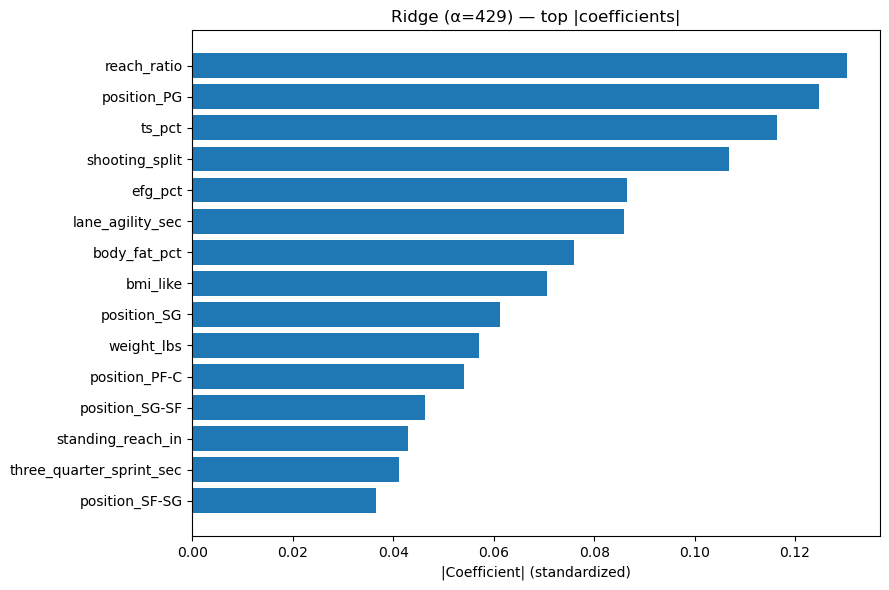

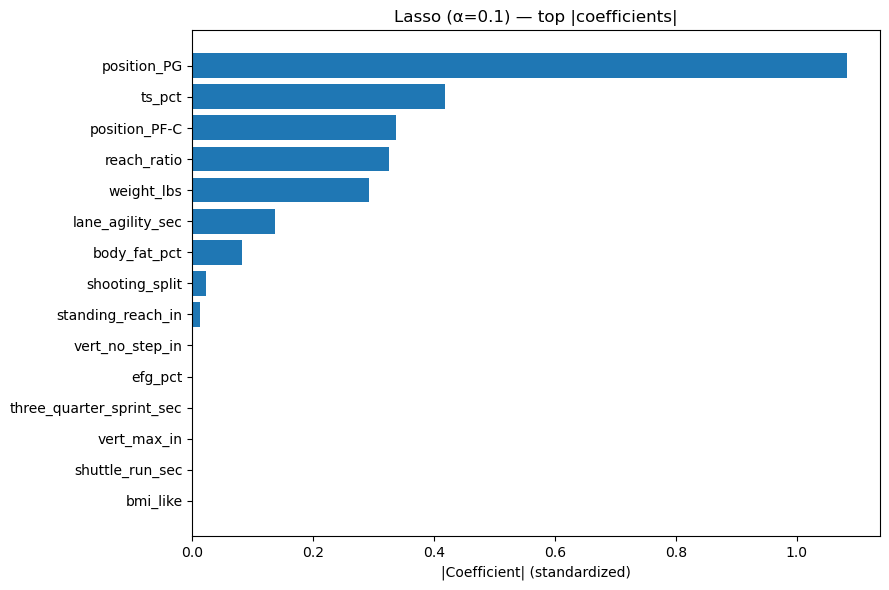

In [12]:

def plot_top_coefs(coefs, names, topk=15, title="Top coefficients by |value|", outpath=None):
    order = np.argsort(np.abs(coefs))[::-1][:topk]
    vals  = np.abs(np.asarray(coefs)[order])
    labs  = np.array(names)[order]

    plt.figure(figsize=(9, 6))
    plt.barh(range(len(vals)), vals)
    plt.yticks(range(len(vals)), labs)
    plt.gca().invert_yaxis()
    plt.xlabel("|Coefficient| (standardized)")
    plt.title(title)
    plt.tight_layout()
    if outpath:
        plt.savefig(outpath, dpi=160)
    plt.show()

plot_top_coefs(ridge_coef, feat_names, topk=15,
               title=f"Ridge (α={best_ridge_alpha:.3g}) — top |coefficients|",
               outpath="outputs/ridge_top_coeffs.png")

plot_top_coefs(lasso_coef, feat_names, topk=15,
               title=f"Lasso (α={best_lasso_alpha:.3g}) — top |coefficients|",
               outpath="outputs/lasso_top_coeffs.png")


In [13]:

merged_plus.to_csv("outputs/merged_training_table.csv", index=False)
pd.DataFrame([
    {"model":"linear_baseline", **baseline_metrics},
    {"model":"ridge_cv", "MAE":ridge_scores["MAE"], "RMSE":ridge_scores["RMSE"], "R2":ridge_scores["R2"]},
    {"model":"lasso_cv", "MAE":lasso_scores["MAE"], "RMSE":lasso_scores["RMSE"], "R2":lasso_scores["R2"]},
]).to_csv("outputs/model_metrics.csv", index=False)

print("✅ Wrote outputs/merged_training_table.csv, outputs/model_metrics.csv, outputs/regularized_coefs.csv")


✅ Wrote outputs/merged_training_table.csv, outputs/model_metrics.csv, outputs/regularized_coefs.csv


In [14]:
model_metrics = pd.DataFrame({
    "Model": ["DecisionTree", "RandomForest", "XGBoost"],
    "Untuned_MAE": [3.6310359408033825, 2.8164479915433405, 2.8748928533900866],
    "Untuned_RMSE": [4.78664484171682, 3.5807950870074756, 3.7497202160743575],
    "Untuned_R2": [-0.6129042164930766, 0.13015271101712847, 0.014867371808641283],
    "Tuned_MAE": [2.505988445423391, 1.4583489700535897, 1.1461316655857772],
    "Tuned_RMSE": [3.1988374315966204, 1.8291107802988171, 1.4166241869833154],
    "Tuned_R2": [0.350363039172064, 0.7875941831216114, 0.8725922951375965],
})

model_metrics

,Model,Untuned_MAE,Untuned_RMSE,Untuned_R2,Tuned_MAE,Tuned_RMSE,Tuned_R2
0,DecisionTree,3.631036,4.786645,-0.612904,2.505988,3.198837,0.350363
1,RandomForest,2.816448,3.580795,0.130153,1.458349,1.829111,0.787594
2,XGBoost,2.874893,3.749720,0.014867,1.146132,1.416624,0.872592


In [ ]:
!pip install scikit-learn

   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------  8.7/8.7 MB 60.1 MB/s eta 0:00:01
   ---------------------------------------  8.7/8.7 MB 60.1 MB/s eta 0:00:01
   ---------------------------------------  8.7/8.7 MB 60.1 MB/s eta 0:00:01
   ---------------------------------------  8.7/8.7 MB 60.1 MB/s eta 0:00:01
   ---------------------------------------  8.7/8.7 MB 60.1 MB/s eta 0:00:01
   ---------------------------------------  8.7/8.7 MB 60.1 MB/s eta 0:00:01
   ---------------------------------------  8.7/8.7 MB 60.1 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 5.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   -------------- ------------------------- 14.2/38.5 MB 69.0 MB/s eta 0:00:01
   -------------------------------- ------- 30.9/38.5 MB 74.5 MB/s eta 0:00:01
   ---------------------------------------  38.3/38.5 MB 73.0 MB/s eta 0:00:01
   ------

In [15]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [16]:
#loading datasets
class PERDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [17]:
# MLP
class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dims=(64,), dropout=0.0):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [18]:
#renamed merged set
df_model = merged_plus          

# renmaed same columns into different names
numeric_cols = num_cols_plus    
categorical_cols = cat_cols_plus  

X_df = df_model[numeric_cols + categorical_cols]
y = df_model["rookie_per"].astype("float32").values

preprocessor = pre_plus

# fit transform
X_all = preprocessor.fit_transform(X_df)

# converted to float32
if hasattr(X_all, "toarray"):
    X_all = X_all.toarray().astype("float32")
else:
    X_all = np.asarray(X_all, dtype="float32")

print("NN feature matrix shape:", X_all.shape)


NN feature matrix shape: (217, 31)


c:\Users\mulli\miniconda3\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['usage_proxy_per40']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [20]:
# train/ split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

batch_size = 32

train_loader = DataLoader(PERDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(PERDataset(X_test,  y_test),  batch_size=batch_size, shuffle=False)

input_dim = X_train.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# hyperparameter tuning
hyperparams = [
    {"hidden_dims": (64,),      "dropout": 0.0, "lr": 1e-3},
    {"hidden_dims": (64,),      "dropout": 0.0, "lr": 5e-4},
    {"hidden_dims": (128,),     "dropout": 0.0, "lr": 1e-3},
    {"hidden_dims": (128,),     "dropout": 0.0, "lr": 5e-4},
    {"hidden_dims": (128, 64),  "dropout": 0.05, "lr": 1e-3},
    {"hidden_dims": (128, 64),  "dropout": 0.05, "lr": 5e-4},
]

results = []

for hp in hyperparams:
    print("\nTesting hyperparameters:", hp)
    model = MLPRegressor(input_dim, hp["hidden_dims"], hp["dropout"]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=hp["lr"])
    loss_fn = nn.MSELoss()

    num_epochs = 40

    for epoch in range(num_epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()

    # test evaluation
    model.eval()
    preds = []
    actual = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            y_hat = model(xb)
            preds.append(y_hat.cpu().numpy())
            actual.append(yb.numpy())

    y_pred = np.vstack(preds).ravel()
    y_true = np.vstack(actual).ravel()

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_true, y_pred)

    print(f"MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")

    results.append({
        "hidden_dims": hp["hidden_dims"],
        "dropout": hp["dropout"],
        "lr": hp["lr"],
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
    })

nn_results_df = pd.DataFrame(results)
nn_results_df


Train shape: (173, 31) Test shape: (44, 31)

Testing hyperparameters: {'hidden_dims': (64,), 'dropout': 0.0, 'lr': 0.001}
MAE=2.385, RMSE=3.128, R2=-0.301

Testing hyperparameters: {'hidden_dims': (64,), 'dropout': 0.0, 'lr': 0.0005}
MAE=3.161, RMSE=4.117, R2=-1.254

Testing hyperparameters: {'hidden_dims': (128,), 'dropout': 0.0, 'lr': 0.001}
MAE=2.623, RMSE=3.269, R2=-0.420

Testing hyperparameters: {'hidden_dims': (128,), 'dropout': 0.0, 'lr': 0.0005}
MAE=2.262, RMSE=3.154, R2=-0.323

Testing hyperparameters: {'hidden_dims': (128, 64), 'dropout': 0.05, 'lr': 0.001}
MAE=2.812, RMSE=3.373, R2=-0.513

Testing hyperparameters: {'hidden_dims': (128, 64), 'dropout': 0.05, 'lr': 0.0005}
MAE=2.741, RMSE=3.393, R2=-0.530


,hidden_dims,dropout,lr,MAE,RMSE,R2
0,"(64,)",0.00,0.0010,2.384812,3.128473,-0.301147
1,"(64,)",0.00,0.0005,3.161229,4.117437,-1.253801
2,"(128,)",0.00,0.0010,2.623308,3.268531,-0.420257
3,"(128,)",0.00,0.0005,2.261975,3.154228,-0.322659
4,"(128, 64)",0.05,0.0010,2.812262,3.373449,-0.512900
5,"(128, 64)",0.05,0.0005,2.741230,3.392890,-0.530387
